In [72]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

Time 范围 2022.10.01 - 2023.11.01

In [73]:
dataset = pd.read_csv("../2019-2023full_data/data_info_main_par.csv")
dataset.head()

,Time,Temperature,Relative Humidity
0,2019-07-31 00:02:00,27,94
1,2019-07-31 01:02:00,27,93
2,2019-07-31 02:02:00,27,89
3,2019-07-31 03:02:00,28,84
4,2019-07-31 03:46:00,28,84


In [74]:
data_2020 = dataset[dataset["Time"].str.startswith("2020")]
data_2020

,Time,Temperature,Relative Humidity
4067,2020-01-01 00:02:00,18,82
4068,2020-01-01 02:02:00,18,83
4069,2020-01-01 03:02:00,18,85
4070,2020-01-01 04:02:00,17,86
4071,2020-01-01 05:02:00,17,85
...,...,...,...
12643,2020-12-31 19:02:00,12,35
12644,2020-12-31 20:02:00,12,40
12645,2020-12-31 21:02:00,11,44
12646,2020-12-31 22:02:00,11,38


In [78]:
data_2020["Time"] = pd.to_datetime(data_2020["Time"])
# 根据日期（天）对数据进行分组，并计算每一天的平均气温
daily_average = data_2020.groupby(data_2020["Time"].dt.date)["Temperature"].mean()

# 创建一个新的DataFrame，包含日期和对应的平均气温
new_data_2020 = pd.DataFrame({"Time": daily_average.index, "Temperature": daily_average.values})
new_data_2020["Time"] = new_data_2020["Time"].astype(str).str[-5:]
new_data_2020.drop(59,inplace=True)

/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/3968466471.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020["Time"] = pd.to_datetime(data_2020["Time"])


In [79]:
data_2021 = dataset[dataset["Time"].str.startswith("2021")]
data_2021["Time"] = pd.to_datetime(data_2021["Time"])
# 根据日期（天）对数据进行分组，并计算每一天的平均气温
daily_average = data_2021.groupby(data_2021["Time"].dt.date)["Temperature"].mean()

# 创建一个新的DataFrame，包含日期和对应的平均气温
new_data_2021 = pd.DataFrame({"Time": daily_average.index, "Temperature": daily_average.values})
new_data_2021["Time"] = new_data_2021["Time"].astype(str).str[-5:]

/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/2328750530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2021["Time"] = pd.to_datetime(data_2021["Time"])


In [80]:
data_2022 = dataset[dataset["Time"].str.startswith("2022")]
data_2022["Time"] = pd.to_datetime(data_2022["Time"])
# 根据日期（天）对数据进行分组，并计算每一天的平均气温
daily_average = data_2022.groupby(data_2022["Time"].dt.date)["Temperature"].mean()

# 创建一个新的DataFrame，包含日期和对应的平均气温
new_data_2022 = pd.DataFrame({"Time": daily_average.index, "Temperature": daily_average.values})
new_data_2022["Time"] = new_data_2022["Time"].astype(str).str[-5:]

/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/3661187256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022["Time"] = pd.to_datetime(data_2022["Time"])


In [81]:
data_2023 = dataset[dataset["Time"].str.startswith("2023")]
data_2023["Time"] = pd.to_datetime(data_2023["Time"])
# 根据日期（天）对数据进行分组，并计算每一天的平均气温
daily_average = data_2023.groupby(data_2023["Time"].dt.date)["Temperature"].mean()

# 创建一个新的DataFrame，包含日期和对应的平均气温
new_data_2023 = pd.DataFrame({"Time": daily_average.index, "Temperature": daily_average.values})
new_data_2023["Time"] = new_data_2023["Time"].astype(str).str[-5:]

/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/3989353532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023["Time"] = pd.to_datetime(data_2023["Time"])


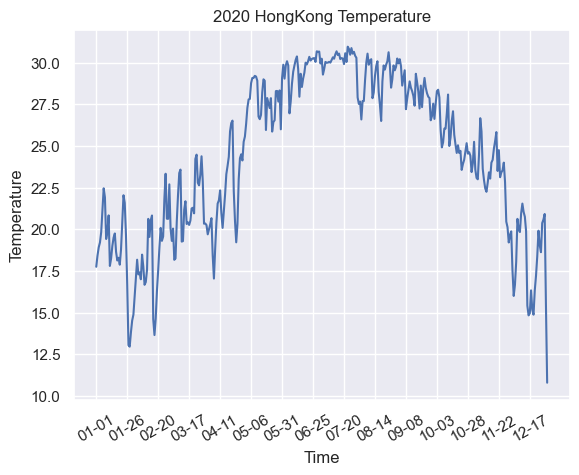

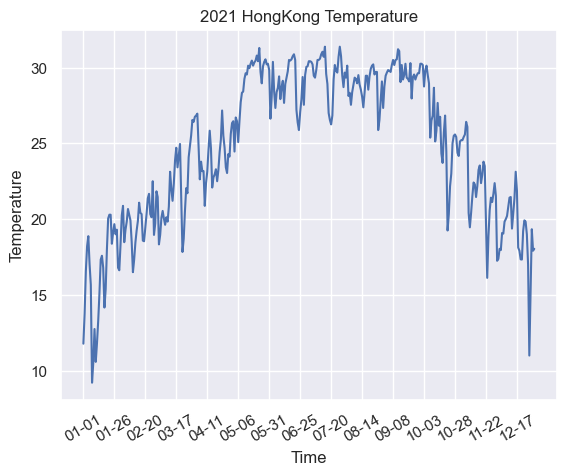

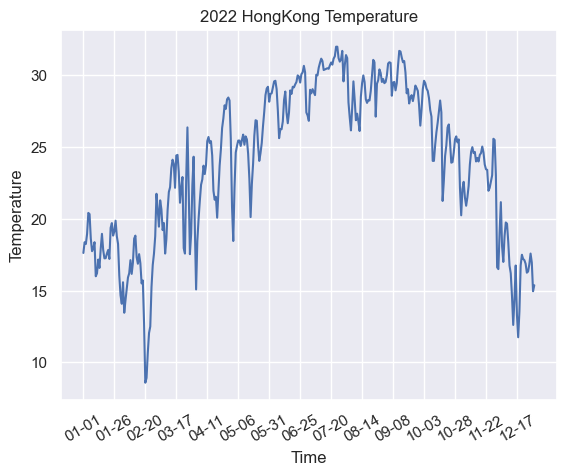

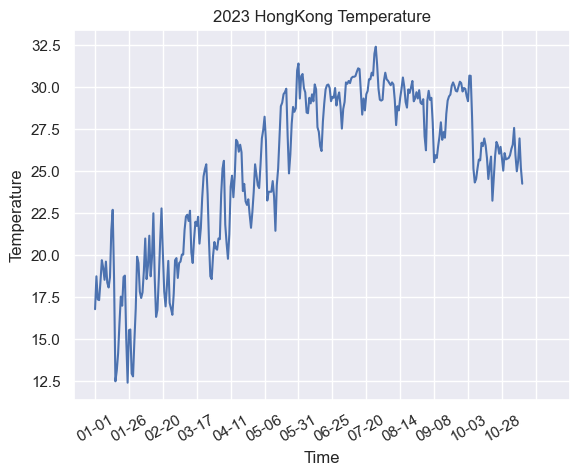

In [87]:
sns.set()
plt.plot(new_data_2020["Time"],new_data_2020["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2020 HongKong Temperature")
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.show()

plt.plot(new_data_2021["Time"],new_data_2021["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2021 HongKong Temperature")
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.show()

plt.plot(new_data_2022["Time"],new_data_2022["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2022 HongKong Temperature")
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.show()

plt.plot(new_data_2023["Time"],new_data_2023["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2023 HongKong Temperature")
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.show()

/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/4057265494.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(new_data_2020["Time"],rotation=60)
/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/4057265494.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(new_data_2021["Time"],rotation=60)
/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/4057265494.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(new_data_2022["Time"],rotation=60)
/var/folders/mr/hjzx11n52x57k_0j1xkt5w4r0000gn/T/ipykernel_85739/4057265494.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks()

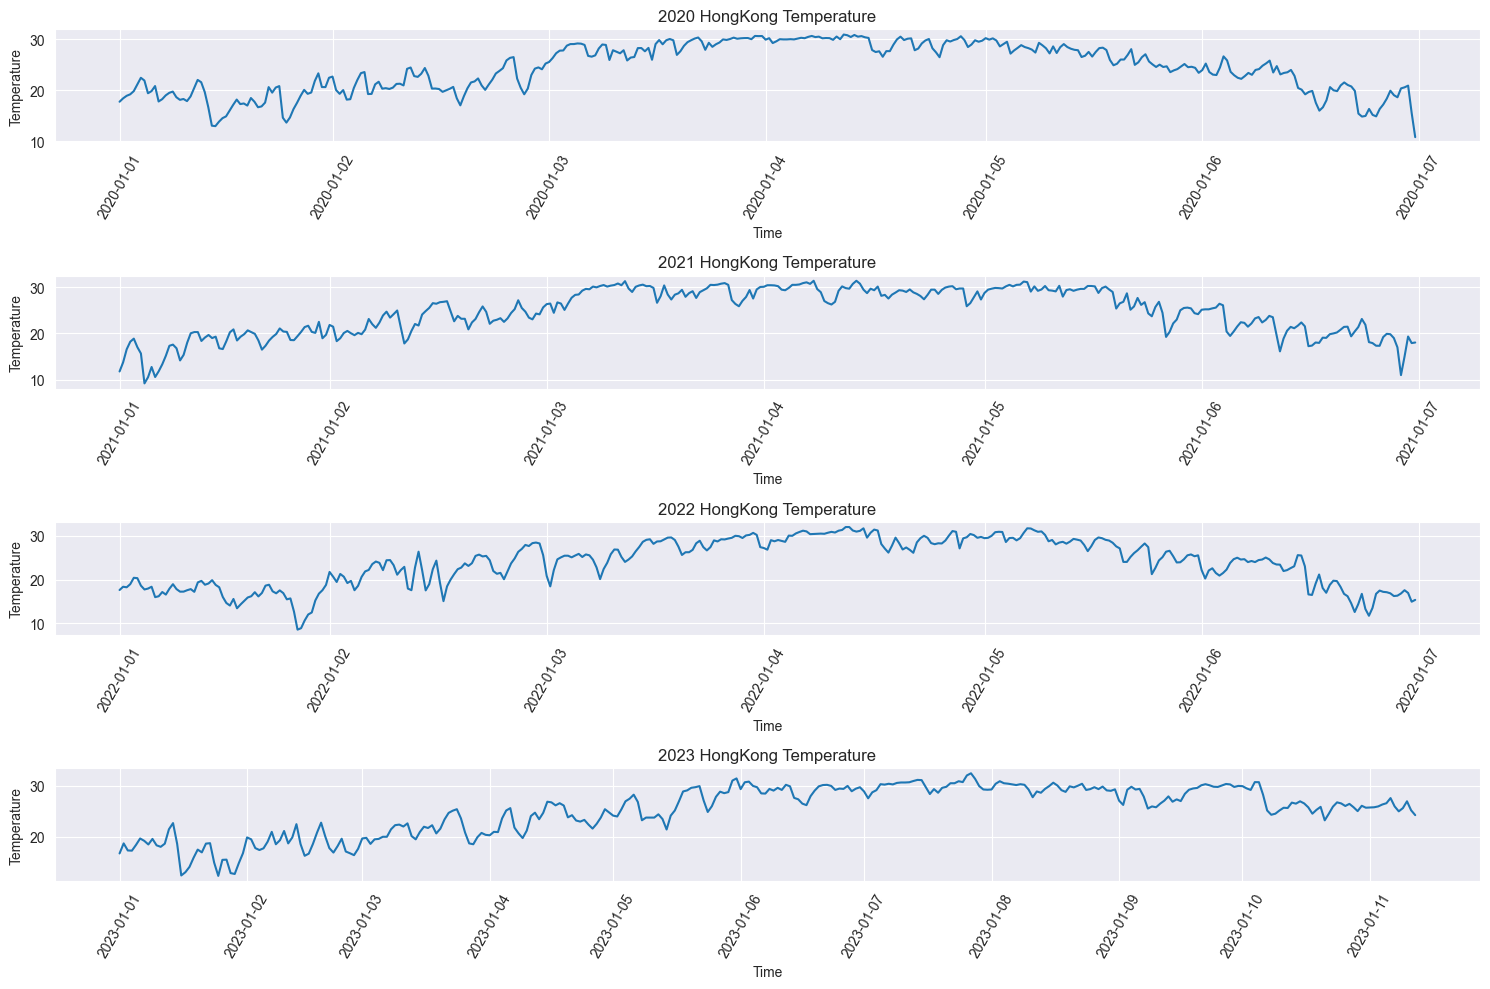

In [68]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
# 在第一个子图上绘制图形
axes[0].plot(new_data_2020["Time"],new_data_2020["Temperature"])
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Temperature")
axes[0].set_xticklabels(new_data_2020["Time"],rotation=60)
axes[0].set_title("2020 HongKong Temperature")

# 在第二个子图上绘制图形
axes[1].plot(new_data_2021["Time"],new_data_2021["Temperature"])
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Temperature")
axes[1].set_xticklabels(new_data_2021["Time"],rotation=60)
axes[1].set_title("2021 HongKong Temperature")

# 在第三个子图上绘制图形
axes[2].plot(new_data_2022["Time"],new_data_2022["Temperature"])
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Temperature")
axes[2].set_xticklabels(new_data_2022["Time"],rotation=60)
axes[2].set_title("2022 HongKong Temperature")

# 在第四个子图上绘制图形
axes[3].plot(new_data_2023["Time"],new_data_2023["Temperature"])
axes[3].set_xlabel("Time")
axes[3].set_ylabel("Temperature")
axes[3].set_xticklabels(new_data_2023["Time"],rotation=60)
axes[3].set_title("2023 HongKong Temperature")

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


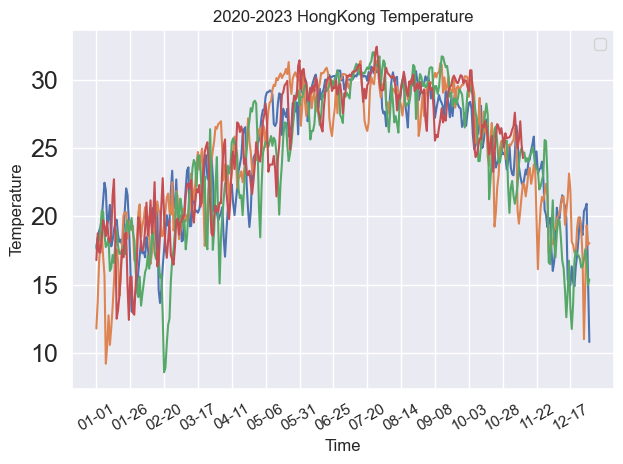

In [86]:
sns.set()
plt.plot(new_data_2020["Time"],new_data_2020["Temperature"])

plt.plot(new_data_2021["Time"],new_data_2021["Temperature"])

plt.plot(new_data_2022["Time"],new_data_2022["Temperature"])

plt.plot(new_data_2023["Time"],new_data_2023["Temperature"])
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("2020-2023 HongKong Temperature")
# 显示图形
plt.xticks(range(0,len(new_data_2020["Time"]),25),rotation=30)
plt.yticks(size=18)
plt.tight_layout()
# 添加图例
plt.legend()
plt.show()